# CIFAR10 Training


The training setup is the same one that has also been used by Zhang et al. For more details see their [paper](https://arxiv.org/abs/1901.09321) and their [sample code](https://github.com/hongyi-zhang/Fixup).

In [ ]:
! pip uninstall torch torchvision -y
! pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Uninstalling torch-1.7.0+cu101:
  Successfully uninstalled torch-1.7.0+cu101
Uninstalling torchvision-0.8.1+cu101:
  Successfully uninstalled torchvision-0.8.1+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu101/torch-1.7.0%2Bcu101-cp37-cp37m-linux_x86_64.whl
  Using cached https://download.pytorch.org/whl/cu101/torchvision-0.8.1%2Bcu101-cp37-cp37m-linux_x86_64.whl


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import platform

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.7.10
torch version:       1.7.0+cu101
torchvision version: 0.8.1+cu101
numpy version:       1.19.5
matplotlib version:  3.2.2
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla T4

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


Put CUDNN to deterministic and set seed values for [reproducibility reasons](https://pytorch.org/docs/stable/notes/randomness.html).

In [ ]:
random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

Let's set some parameters.

In [ ]:
num_epochs = 200                                         # number of training epochs
batch_size_train = 128                                   # batch size for training
batch_size_test = 1000                                   # batch size for testing
alpha = 1.                                               # alpha
base_lr = 0.1                                            # learning rate for training
base_learning_rate = base_lr * batch_size_train / 128.   # base learning rate
mom = 0.9                                                # momentum
decay = 1e-4                                             # weight decay
use_sgdr = True                                          # use sgdr
calibset_size = 750                                      # size of the calibration set (should be used for calculating a confidence score later)

log_interval = 10                                        # printing training statistics after 10 iterations

## Data

### Specify Dataset

Define data transform functions for training and test set.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Define training, test and calibration set.

In [ ]:
# Training set
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)

# Test set and calibration set
orig_testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)
orig_testset_size = len(orig_testset)

testset_size = orig_testset_size - calibset_size
testset, calibset = torch.utils.data.random_split(orig_testset, [testset_size, calibset_size])

Files already downloaded and verified
Files already downloaded and verified


### Load Data

Create train, test and calibration data loader.

In [ ]:
# Create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=2
)

# Create test data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=2
)

# Create calib data loader
calibloader = torch.utils.data.DataLoader(
    calibset, batch_size=calibset_size, shuffle=False, num_workers=2
)

Print out the sizes of the datasets.

In [ ]:
print('trainset size: {}'.format(len(trainloader.dataset)))
print('testset size:  {}'.format(len(testloader.dataset)))
print('calibset size: {}'.format(len(calibloader.dataset)))

trainset size: 50000
testset size:  9250
calibset size: 750


### Display Samples

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        img[0] = img[0] * 0.2023 + 0.4914
        img[1] = img[1] * 0.1994 + 0.4822
        img[2] = img[2] * 0.2010 + 0.4465
        img = np.clip(img, 0, 1)
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title("Ground Truth: {}".format(classes[targets[i]]))
        
        plt.xticks([])
        plt.yticks([])

Load a few test images and display them.

tensor shape: (1000, 3, 32, 32)


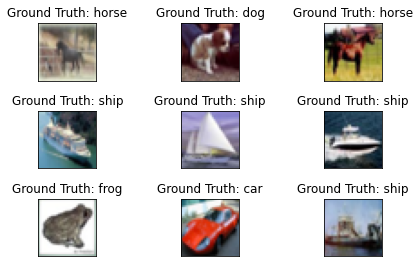

In [ ]:
dataiter = enumerate(testloader)
_, (sample_data, sample_targets) = next(dataiter)

show_samples(sample_data, sample_targets)

## Define Training and Test Functions

Let's define the functions for training and testing.

In [ ]:
def train(num_epochs, model, optim, sgdr, cel, crit, train_loader, test_loader):
    train_losses = []
    test_losses = []
    test_accs = []
    
    for epoch in range(1, num_epochs + 1):
        model, train_losses = train_one_epoch(epoch, model, optim, crit, train_loader, train_losses)

        lr = 0.
        if use_sgdr:
            sgdr.step()
            for param_group in optim.param_groups:
                lr = param_group['lr']
                break
        else:
            lr = adjust_learning_rate(optim, epoch)

        test_losses, test_accs = test(model, cel, test_loader, test_losses, test_accs)
        
    print('Finished Training')
    return train_losses, test_losses, test_accs


def train_one_epoch(epoch_num, model, optim, crit, data_loader, losses):
    model.train()
    running_loss = 0.0
    
    for batch_idx, data in enumerate(data_loader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, targets = data

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha, use_cuda)
        
        # Zero the parameter gradients
        optim.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss_func = mixup_criterion(targets_a, targets_b, lam)
        loss = loss_func(crit, outputs)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            dataset_size = len(data_loader.dataset)
            used_samples = batch_idx * len(inputs)
            train_progress = 100. * batch_idx / len(data_loader)
            avg_batch_loss = running_loss / log_interval
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num, used_samples, dataset_size, train_progress, avg_batch_loss
            ))
            
            losses.append(avg_batch_loss)
            running_loss = 0.0
                
    return model, losses

    
def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = base_learning_rate
    if epoch <= 9 and lr > 0.1:
        # warm-up training for large minibatch
        lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        if param_group['initial_lr'] == base_learning_rate:
            param_group['lr'] = lr
        else:
            if epoch <= 9:
                param_group['lr'] = param_group['initial_lr'] * lr / base_learning_rate
            elif epoch < 100:
                param_group['lr'] = param_group['initial_lr']
            elif epoch < 150:
                param_group['lr'] = param_group['initial_lr'] / 10.
            else:
                param_group['lr'] = param_group['initial_lr'] / 100.
    return lr
     
    
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in data_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
              inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

## Network Architecture

Let's define the Fixup-ResNet20 architecture for CIFAR10 that was used by Zhang et al.

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True, per_sample=False):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    if alpha > 0. and not per_sample:
        lam = torch.zeros(y.size()).fill_(np.random.beta(alpha, alpha)).cuda()
        mixed_x = lam.view(-1, 1, 1, 1) * x + (1 - lam.view(-1, 1, 1, 1)) * x[index,:]
    elif alpha > 0.:
        lam = torch.Tensor(np.random.beta(alpha, alpha, size=y.size())).cuda()
        mixed_x = lam.view(-1, 1, 1, 1) * x + (1 - lam.view(-1, 1, 1, 1)) * x[index,:]
    else:
        lam = torch.ones(y.size()).cuda()
        mixed_x = x

    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_lam_idx(batch_size, alpha, use_cuda=True):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    return lam, index    


def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: criterion(pred, y_a, lam) + criterion(pred, y_b, 1 - lam)


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std


def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

                
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class FixupBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(FixupBasicBlock, self).__init__()
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.bias1a = nn.Parameter(torch.zeros(1))
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bias1b = nn.Parameter(torch.zeros(1))
        self.relu = nn.ReLU(inplace=True)
        self.bias2a = nn.Parameter(torch.zeros(1))
        self.conv2 = conv3x3(planes, planes)
        self.scale = nn.Parameter(torch.ones(1))
        self.bias2b = nn.Parameter(torch.zeros(1))
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x + self.bias1a)
        out = self.relu(out + self.bias1b)

        out = self.conv2(out + self.bias2a)
        out = out * self.scale + self.bias2b

        if self.downsample is not None:
            identity = self.downsample(x + self.bias1a)
            identity = torch.cat((identity, torch.zeros_like(identity)), 1)

        out += identity
        out = self.relu(out)

        return out


class FixupResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        super(FixupResNet, self).__init__()
        self.num_layers = sum(layers)
        self.inplanes = 16
        self.conv1 = conv3x3(3, 16)
        self.bias1 = nn.Parameter(torch.zeros(1))
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.bias2 = nn.Parameter(torch.zeros(1))
        self.fc = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, FixupBasicBlock):
                nn.init.normal_(m.conv1.weight, mean=0, std=np.sqrt(2 / (m.conv1.weight.shape[0] * np.prod(m.conv1.weight.shape[2:]))) * self.num_layers ** (-0.5))
                nn.init.constant_(m.conv2.weight, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 0)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.AvgPool2d(1, stride=stride)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x + self.bias1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x + self.bias2)

        return x


def fixup_resnet20(**kwargs):
    """Constructs a Fixup-ResNet-20 model.
    """
    model = FixupResNet(FixupBasicBlock, [3, 3, 3], **kwargs)
    return model

## Model Training

Let's train the model.

In [ ]:
# Create Model
model = fixup_resnet20()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

# Define Optimizer
cel = nn.CrossEntropyLoss()
criterion = lambda pred, target, lam: (-F.log_softmax(pred, dim=1) * torch.zeros(pred.size()).cuda().scatter_(1, target.data.view(-1, 1), lam.view(-1, 1))).sum(dim=1).mean()
parameters_bias = [p[1] for p in model.named_parameters() if 'bias' in p[0]]
parameters_scale = [p[1] for p in model.named_parameters() if 'scale' in p[0]]
parameters_others = [p[1] for p in model.named_parameters() if not ('bias' in p[0] or 'scale' in p[0])]
optimizer = optim.SGD(
    [
        {'params': parameters_bias, 'lr': base_lr/10.}, 
        {'params': parameters_scale, 'lr': base_lr/10.}, 
        {'params': parameters_others}
    ], 
    lr=base_learning_rate, 
    momentum=mom, 
    weight_decay=decay
)

sgdr = CosineAnnealingLR(optimizer, num_epochs, eta_min=0, last_epoch=-1)

# Start Training
_, _, accs = train(num_epochs, model, optimizer, sgdr, cel, criterion, trainloader, testloader)

print()
print('Accuracies: {}'.format(accs))

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 84 [39680/50000 (79%)]	Loss: 1.319357
Train Epoch: 84 [40960/50000 (82%)]	Loss: 1.131843
Train Epoch: 84 [42240/50000 (84%)]	Loss: 1.190307
Train Epoch: 84 [43520/50000 (87%)]	Loss: 1.164256
Train Epoch: 84 [44800/50000 (90%)]	Loss: 1.041701
Train Epoch: 84 [46080/50000 (92%)]	Loss: 1.205570
Train Epoch: 84 [47360/50000 (95%)]	Loss: 1.253714
Train Epoch: 84 [48640/50000 (97%)]	Loss: 1.118697
Train Epoch: 84 [31200/50000 (100%)]	Loss: 1.089067

Test set: Avg. loss: 0.000431, Accuracy: 8241/9250 (89.09%)

Train Epoch: 85 [0/50000 (0%)]	Loss: 0.141120
Train Epoch: 85 [1280/50000 (3%)]	Loss: 1.113729
Train Epoch: 85 [2560/50000 (5%)]	Loss: 1.059148
Train Epoch: 85 [3840/50000 (8%)]	Loss: 1.251486
Train Epoch: 85 [5120/50000 (10%)]	Loss: 0.855420
Train Epoch: 85 [6400/50000 (13%)]	Loss: 0.963817
Train Epoch: 85 [7680/50000 (15%)]	Loss: 1.104524
Train Epoch: 85 [8960/50000 (18%)]	Loss: 1.038729
Train Epoch: 85 [1

Put model in evaluation mode.

In [ ]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

Using  1  GPU(s)


Let's test our model again to see again which accuracy we have finally reached.

In [ ]:
def test_final(model, data_loader):
    _, accs = test(model, cel, data_loader, [], [])
    return accs[0]

In [ ]:
test_acc = test_final(model, testloader); test_acc


Test set: Avg. loss: 0.000327, Accuracy: 8549/9250 (92.42%)



92.42162162162163

Let's save the model.

In [ ]:
torch.save(model.state_dict(), "./cifar10_model.pth")

In [ ]:
! ls

cifar10_model.pth  data  sample_data


In [ ]:
from google.colab import files
files.download('./cifar10_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>